In [1]:
import pandas as pd
import numpy as np
import pickle
import os


from sklearn.metrics import make_scorer, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import TunedThresholdClassifierCV


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import importlib
import scripts.variables as var
import playsound


def play_done_message():
    playsound.playsound("./data/MamaDoIt.mp3")


importlib.reload(var)


print('DONE')

DONE


In [2]:
#Functions
def custom_score(y_test, predictions, fp_cost=1, fn_cost=1):
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    return fn*fn_cost + fp * fp_cost

def custom_score_fn_doubled(y_test, predictions, fp_cost=1, fn_cost=2):
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    return fn*fn_cost + fp * fp_cost

# Goal.
> Once you selected your model, what about to incorporate the cost. What if I am able (a HUGE if) to measure the cost of errors? I estate this: the cost of missing one potential "yes" is double (2) compared to the cost of calling a client that would not contract the product (1).

In [13]:
with open ('model_pickled.pkl','rb') as MODEL:
    data_to_save=pickle.load(MODEL)

In [14]:
pipeline, X_test, y_test,X_train,y_train, cv=data_to_save
preds=pipeline.predict(X_test)

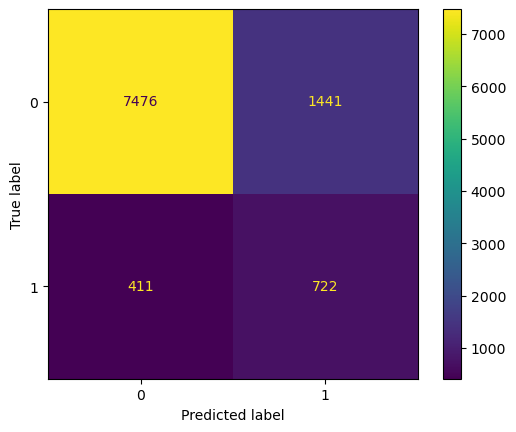

In [16]:
_ = ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)

## The cost when errors have the same weight

In [7]:
#let's evaluate the Falses Positives and Negatives
#Being the cost of FP and FN the same and TP and TN having no cost at all
tn, fp, fn, tp = confusion_matrix(y_test,preds).ravel() 
print('Cost: ', custom_score(y_test, preds))

Cost:  1828


### Let's do fn=2 and fp=1

In [20]:
print('Cost: ', custom_score(y_test,preds,fn_cost=2))

Cost:  2263


In [21]:
custom_scorer = make_scorer(
    custom_score_fn_doubled, response_method="predict", greater_is_better=False
)
tuned_classifier = TunedThresholdClassifierCV(
    pipeline, cv=cv, scoring=custom_scorer
).fit(X_train, y_train)

print(f"Tuned decision threshold: {tuned_classifier.best_threshold_:.3f}")
print(f"Custom score: {custom_score(y_test, tuned_classifier.predict(X_test),):.2f}")

Tuned decision threshold: 0.805
Custom score: 1106.00


In [227]:
##checking it out: doing it manually
#tn, fp, fn, tp = confusion_matrix(y_test,preds).ravel()
print('cutoff: ', tuned_classifier.best_threshold_)
tuned_y=tuned_classifier.predict(X_test)
tuned_proba=tuned_classifier.predict_proba(X_test)
to_compare= list(zip(tuned_y, tuned_proba))
to_compare[:20]
# tn, fp, fn, tp = confusion_matrix(y_test,tuned_y).ravel()
# custom_score(y_test,tuned_y,fn_cost=2)

cutoff:  0.8046774143871709


[(0, array([0.62071063, 0.37928937])),
 (0, array([0.83120533, 0.16879467])),
 (0, array([0.7506804, 0.2493196])),
 (0, array([0.66437279, 0.33562721])),
 (0, array([0.67420755, 0.32579245])),
 (0, array([0.74846008, 0.25153992])),
 (0, array([0.75110312, 0.24889688])),
 (0, array([0.47300887, 0.52699113])),
 (1, array([0.12481737, 0.87518263])),
 (0, array([0.81643921, 0.18356079])),
 (0, array([0.7650674, 0.2349326])),
 (0, array([0.75093143, 0.24906857])),
 (0, array([0.35115009, 0.64884991])),
 (0, array([0.68669324, 0.31330676])),
 (0, array([0.47525965, 0.52474035])),
 (0, array([0.77915437, 0.22084563])),
 (0, array([0.74134249, 0.25865751])),
 (0, array([0.72931949, 0.27068051])),
 (0, array([0.69541811, 0.30458189])),
 (0, array([0.7144235, 0.2855765]))]

In [221]:
tn, fp, fn, tp = confusion_matrix(y_test,tuned_y).ravel()
print('Accuracy: ', (tn+tp)/len(tuned_y))
print('Recall: ', tp/(tp+fn))

Accuracy:  0.8992039800995025
Recall:  0.19064430714916153


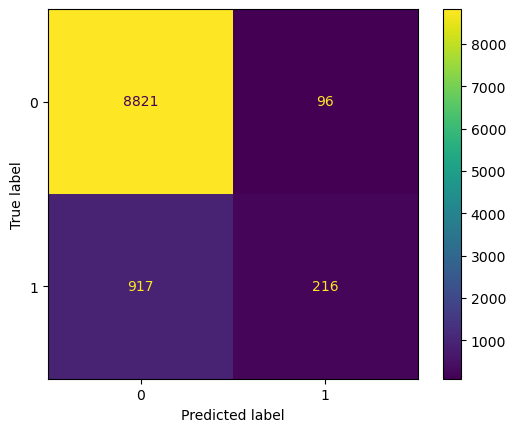

In [217]:
_ = ConfusionMatrixDisplay.from_predictions(y_test, tuned_y)

2. **Using only selected features with SMOTE and Logistic Regression.**

In [181]:
all_features=numerical_columns + categorical_columns + boolean_columns
X,y =creating_X_y(bank, all_features)
selected_features= top_numerical[:-2] + top_categorical[:-2]
X=X[selected_features]
X_train, X_test, y_train, y_test=train_test_split(X,y,stratify=y, random_state=1992)
model=LogisticRegression(max_iter=500)
upsampling=SMOTE()
scaler=StandardScaler()
pipeline=Pipeline([('Scaler',scaler),('SMOTE', upsampling),('Logistic Regression', model)])
cv=StratifiedKFold()
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score)
}
scores=cross_validate(pipeline,X_train,y_train, scoring=scoring, cv=cv)
print(f'My scores in train validation are {scores["test_recall"].mean().round(3)} recall,{scores["test_f1"].mean().round(3)} as per f1 and an accuracy of {scores["test_accuracy"].mean().round(3)}')
pipeline.fit(X_train,y_train)
preds_lr=pipeline.predict(X_test)
print(f'As per the test: {round(recall_score(y_test,preds_lr),3)} recall, the f1 is {round(f1_score(y_test,preds_lr),3)}\
 and its accuracy amounts to {round(accuracy_score(y_test,preds_lr),3)}')

My scores in train validation are 0.638 recall,0.439 as per f1 and an accuracy of 0.816
As per the test: 0.639 recall, the f1 is 0.44 and its accuracy amounts to 0.817


In [ ]:
#confusion matrix


> Lost a little bit of recall while gaining some accuracy. Does not worth limiting features. I tried different number of features with similar results. As I reduce the number of features my recall increases up to 72 points while accuracy pays for it going down to 72. It is all well explained looking at f1 score: down to 35 from 44 in the worst case. Something similar happened when I use a downsampler instead of SMOTE

3. **Moving to random Forest**

In [180]:
all_features=numerical_columns + categorical_columns + boolean_columns
X,y =creating_X_y(bank, all_features)
selected_features= top_4_numerical + top_10_cat
X=X[selected_features]
X_train, X_test, y_train, y_test=train_test_split(X,y,stratify=y, random_state=1992)
model=RandomForestClassifier()
upsampling=SMOTE()
scaler=StandardScaler()
pipeline=Pipeline([('Scaler',scaler),('SMOTE', upsampling),('random Forest', model)])
cv=StratifiedKFold()
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score)
}
scores=cross_validate(pipeline,X_train,y_train, scoring=scoring, cv=cv)
print(f'My scores in train validation are {scores["test_recall"].mean().round(3)} recall,{scores["test_f1"].mean().round(3)} as per f1 and an accuracy of {scores["test_accuracy"].mean().round(3)}')
pipeline.fit(X_train,y_train)
preds_rf=pipeline.predict(X_test)
print(f'As per the test: {round(recall_score(y_test,preds_rf),3)} recall, the f1 is {round(f1_score(y_test,preds_rf),3)}\
 and its accuracy amounts to {round(accuracy_score(y_test,preds_rf),3)}')

My scores in train validation are 0.444 recall,0.436 as per f1 and an accuracy of 0.87
As per the test: 0.466 recall, the f1 is 0.441 and its accuracy amounts to 0.867


# Summary:
1. Using all features seems to me did not generate overfitting.
2. Logistic regression and SMOTE are more effective detecting the minority class in exchange of losing some accuracy.
3. Must analyze the distribution of FP and FN. 